# Contents:

This notebook contains a short EDA section, as well as two model training approaches. The first model is a deep learning based model implemented in PyTorch, and the second is an Auto ML approach based on the H20 package.

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn as nn
from torch.autograd import Variable 

%config InlineBackend.figure_format = 'retina'

load in the data as described at https://archive.ics.uci.edu/ml/datasets/Energy+efficiency.

In [77]:
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

Based on the data set description, the problem may be treated by taking a building (or two) as a hold out test set. This can be seen by taking a look at the unique values of the X1 variable.

In [78]:
data.X1.value_counts().sort_index()

0.62    64
0.64    64
0.66    64
0.69    64
0.71    64
0.74    64
0.76    64
0.79    64
0.82    64
0.86    64
0.90    64
0.98    64
Name: X1, dtype: int64

In [79]:
data.groupby(['X1', 'X2']).X3.count()

X1    X2   
0.62  808.5    64
0.64  784.0    64
0.66  759.5    64
0.69  735.0    64
0.71  710.5    64
0.74  686.0    64
0.76  661.5    64
0.79  637.0    64
0.82  612.5    64
0.86  588.0    64
0.90  563.5    64
0.98  514.5    64
Name: X3, dtype: int64

With exact correclations between certain variables:

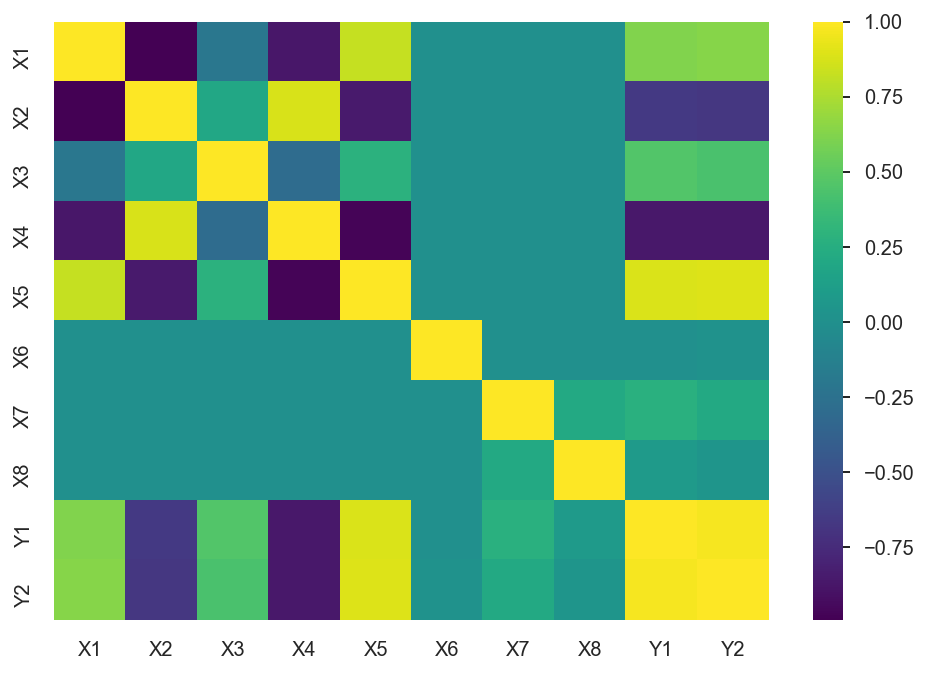

In [80]:
sns.heatmap(data.corr(), cmap='viridis');

In [81]:
def prep_data(data):
    
    # Here two buildings are selected to be treated as a holdout test set:
    test_set = [0.64, 0.79]
    test = data[data.X1.isin(test_set)]
    
    data = data[~data.index.isin(test.index)]
    
    training   = data.sample(frac=0.8)
    validation = data[~data.index.isin(training.index)]
    
    # Data pre-processing. Since we are employing a deep model, one needs to take care to standardize the data:
    
    means = training.mean()
    stds  = training.std()
    
    for frames in [test, validation, training]:
        
        frames -= means
        frames /= stds
    
    return training, validation, test, means, stds

In [82]:
training, validation, test, means, stds  = prep_data(data)

Because the dataset is small, one should take particular care in not using a very deep network since we can easily overfit. In order to ameliorate the potential of overfitting, one common approach is the use of dropout layers:

In [83]:
class Net(nn.Module):
    def __init__(self, input_size=7, output_size=2, num_nodes=5000):
        super(Net, self).__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        
        self.input_layer   = nn.Linear(self.input_size, num_nodes)
        self.middle1       = nn.Linear(num_nodes, num_nodes)
        self.middle2       = nn.Linear(num_nodes, num_nodes)
        self.dropout2      = nn.Dropout()
        self.output_layer  = nn.Linear(num_nodes, self.output_size)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.nn.functional.leaky_relu(x)
        x = self.middle1(x)
        x = torch.nn.functional.leaky_relu(x)
        x = self.middle2(x)
        x = self.dropout2(x)
        x = torch.nn.functional.leaky_relu(x)
        out = self.output_layer(x)
        return out

model = Net(input_size=8)
    
optimizer         = torch.optim.Adam(model.parameters(), lr=1.0e-3)
criterion         = nn.MSELoss()
criterion_measure = nn.MSELoss()

loss_train_list, loss_validation_list, loss_test_list = [], [], []
num_epochs = 100

# Because the dataset is small, implementing a dataloader is not necessary.

# Training phase:
# =================== load data =================== #

# Recall that I shuffle train and validation, so call a new instance of prep_data every epoch.
train, validation, test, means, stds = prep_data(data=data)

X_train = Variable(torch.from_numpy(train[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].values).type(torch.FloatTensor))
y_train = Variable(torch.from_numpy(train[['Y1', 'Y2']].values).type(torch.FloatTensor))

X_test  = Variable(torch.from_numpy(test[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].values).type(torch.FloatTensor))
y_test  = Variable(torch.from_numpy(test[['Y1', 'Y2']].values).type(torch.FloatTensor))

X_val   = Variable(torch.from_numpy(validation[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].values).type(torch.FloatTensor))
y_val   = Variable(torch.from_numpy(validation[['Y1', 'Y2']].values).type(torch.FloatTensor))
    
# =================== training ===================== #
    
for k in tqdm(range(num_epochs)):

    # =================== forward ===================== #
    output_train = model(X_train)
    loss_train = criterion(output_train, y_train)
    loss_train_measure = criterion_measure(output_train, y_train)
    
    output_validation = model(X_val)
    loss_validation_measure = criterion_measure(output_validation, y_val)
    
    output_test = model(X_test)
    loss_test_measure = criterion_measure(output_test, y_test)
    
    # =================== backprop ==================== #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    # =================== logging ===================== #
    loss_train_list.append(torch.sqrt(loss_train_measure.data))
    loss_validation_list.append(torch.sqrt(loss_validation_measure.data))
    loss_test_list.append(torch.sqrt(loss_test_measure.data))

Below I plot the evolution of the loss function for the training, validation, and testing set. If the test set's loss were to increase at any point, we'd know we were overfitting. I ran a few experiments to see that the number of epochs chosen helped to stop before overfitting occurred.

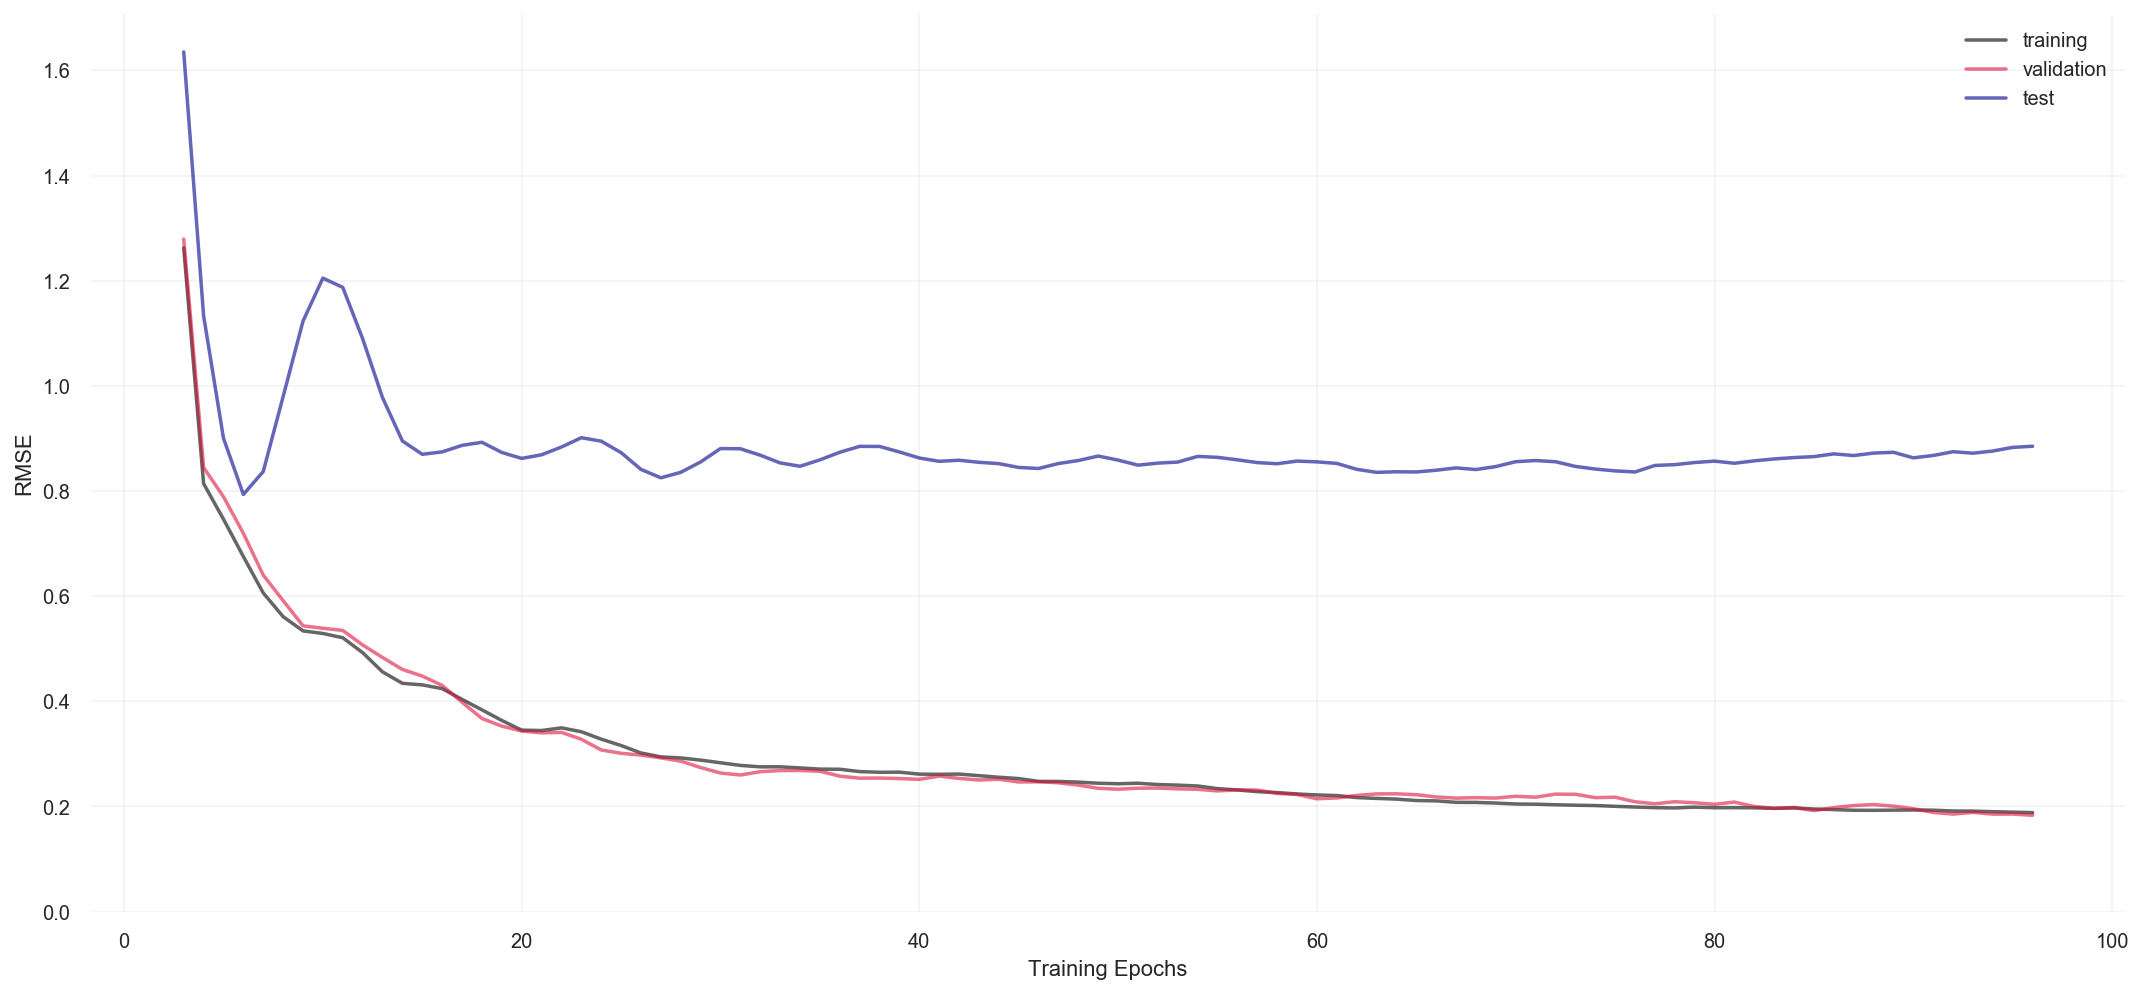

In [87]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(pd.Series(loss_train_list[3:]).rolling(4).mean(),      label='training',   color='k',        alpha=0.6)
ax.plot(pd.Series(loss_validation_list[3:]).rolling(4).mean(), label='validation', color='crimson',  alpha=0.6)
ax.plot(pd.Series(loss_test_list[3:]).rolling(4).mean(),       label='test',       color='darkblue', alpha=0.6)

ax.legend()
ax.set_ylabel('RMSE')
ax.set_xlabel('Training Epochs')
ax.set_ylim(0,)
ax.grid(alpha=0.2)
fig.tight_layout()

Now all that is left to do is to undo the standardized scaling so that we're back in our physical units. Below I also include a plot of prediction vs actual for y1 and y2 to get a sense of our deep net model's performance:

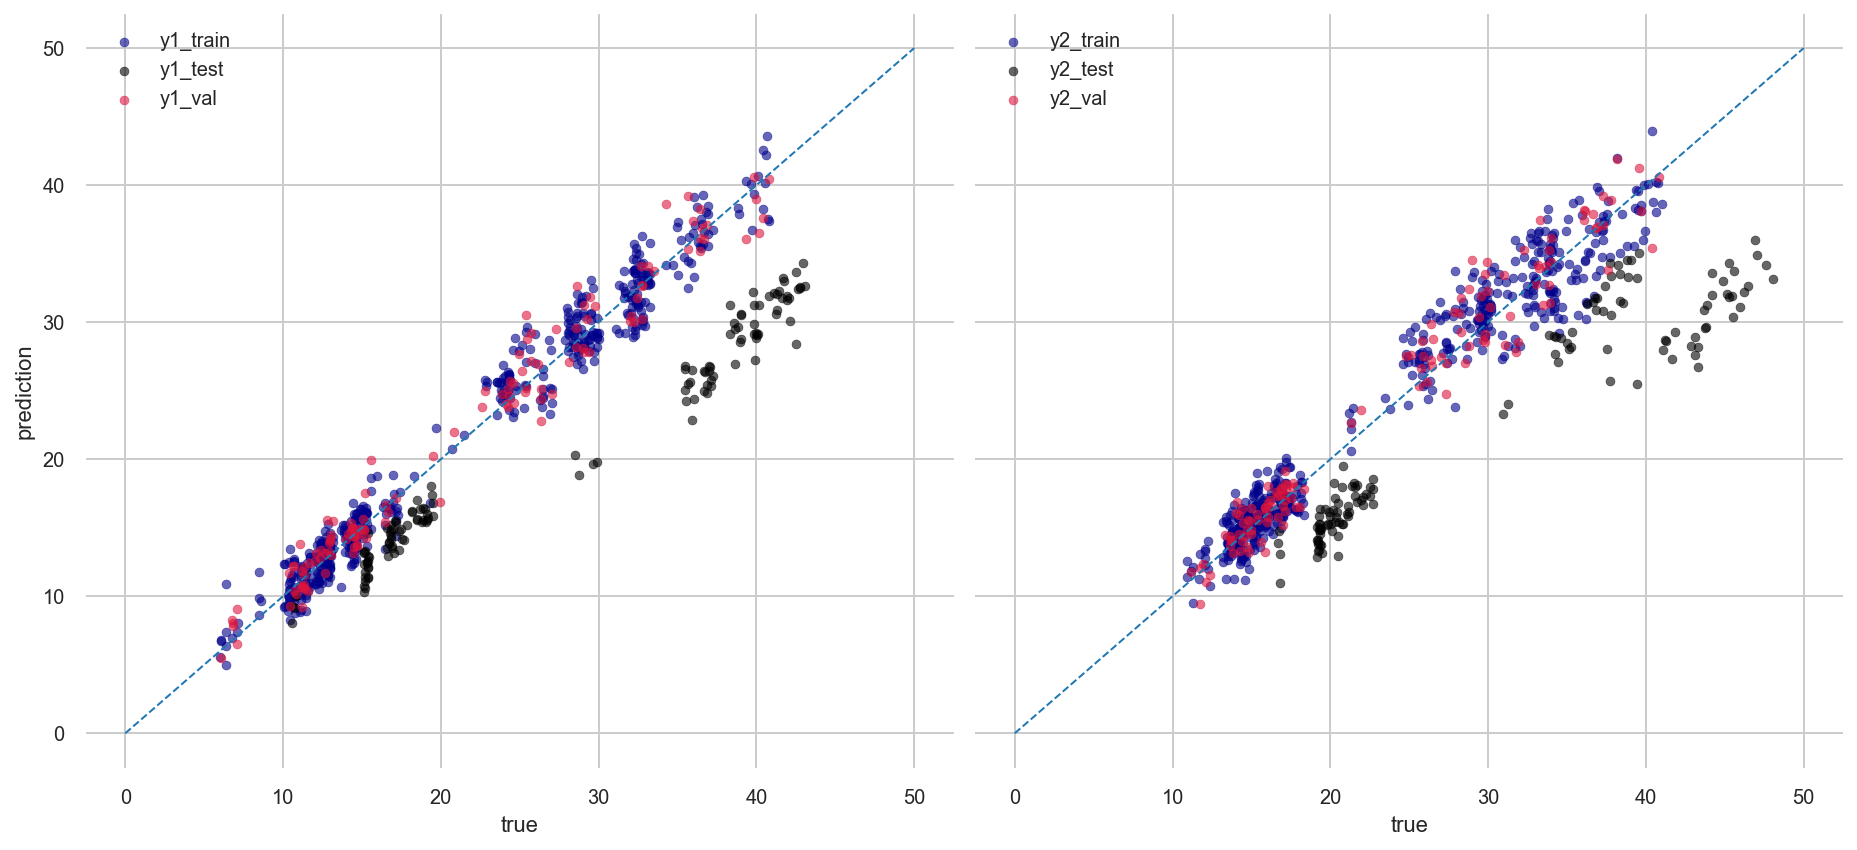

In [88]:
y_test_scaled = y_test.data.numpy()*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values
y_val_scaled  = y_val.data.numpy()*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values
y_train_scaled = y_train.data.numpy()*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

# test
y_test_pred = model(X_test)
y_test_pred_scaled = y_test_pred.data.numpy()*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

# validation
y_val_pred        = model(X_val)
y_val_pred_scaled = y_val_pred.data.numpy()*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

# train
y_train_pred = model(X_train)
y_train_pred_scaled = y_train_pred.data.numpy()*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

fig, ax = plt.subplots(ncols=2, figsize=(13,6), sharey=True)

ax[0].scatter(x=y_train_scaled[:,0], y=y_train_pred_scaled[:,0], label='y1_train', color='darkblue', alpha=0.6, s=20.0)
ax[0].scatter(x=y_test_scaled[:,0],  y=y_test_pred_scaled[:,0],  label='y1_test',  color='black',    alpha=0.6, s=20.0)
ax[0].scatter(x=y_val_scaled[:,0],   y=y_val_pred_scaled[:,0],   label='y1_val',   color='crimson',  alpha=0.6, s=20.0)

ax[1].scatter(x=y_train_scaled[:,1], y=y_train_pred_scaled[:,1], label='y2_train', color='darkblue', alpha=0.6, s=20.0)
ax[1].scatter(x=y_test_scaled[:,1],  y=y_test_pred_scaled[:,1],  label='y2_test',  color='black',    alpha=0.6, s=20.0)
ax[1].scatter(x=y_val_scaled[:,1],   y=y_val_pred_scaled[:,1],   label='y2_val',   color='crimson',  alpha=0.6, s=20.0)

ax[0].plot([0,50],[0,50], lw=1.0, ls='--');
ax[1].plot([0,50],[0,50], lw=1.0, ls='--');

ax[0].legend()
ax[1].legend();

ax[0].set_xlabel('true')
ax[1].set_xlabel('true')

ax[0].set_ylabel('prediction')
    
fig.tight_layout()


# Same approach but with AutoML this time:

In [29]:
import h2o
import pandas as pd
from h2o.automl import H2OAutoML

def load_training_data(train_fraction: float, data):
    """
    Description:
        Function which retrieves data from website url and returns the train/test split.
    
    Input:
        data_url: the source of our dataset.
        train_fraction: parameter specifying how much of the training data to use for training.
        seed: random seed making experiments reproducible.
        
    Returns:
        train and test h2o dataframes.
    """

    test_set = [0.64, 0.79]
    
    test = data[data.X1.isin(test_set)]
    data = data[~data.index.isin(test.index)]
    
    training   = data.sample(frac=0.8)
    validation = data[~data.index.isin(training.index)]
    
    means = training.mean()
    stds  = training.std()
    
    for frames in [test, validation, training]:
        
        frames -= means
        frames /= stds
    
    test = h2o.H2OFrame(test)
    validation = h2o.H2OFrame(validation)
    training = h2o.H2OFrame(training)

    return training, validation, test, means, stds


def train_models(data, train_fraction=0.8, max_train_time=15):
    """
    Description:
        Function which trains two models, one for each response variable (y1, y2).
        A leaderboard is also printed out so one may see which models fared best.
    
    Input:
        data_url: the source of our dataset
        max_train_time (seconds): specifies the max number of seconds for automl to run.
        seed: random seed making experiments reproducible.
        
    Returns:
        Two trained models for each response variable (y1, y2) in that order.
    """
    
    train, validation, test, means, stds = load_training_data(train_fraction, data)   

    print('Running in automl mode:')

    model_y1 = H2OAutoML(max_runtime_secs=max_train_time, seed=1, project_name='ee-model-y1')
    model_y1.train(y='Y1', training_frame=train.drop(['Y2'], 1), leaderboard_frame=test)

    model_y2 = H2OAutoML(max_runtime_secs = max_train_time, seed = 1, project_name = 'ee-model-y2')
    model_y2.train(y='Y2', training_frame=train.drop(['Y1'], 1), leaderboard_frame=test)

    print('')
    print(model_y1.leaderboard)
    print('')
    print(model_y2.leaderboard)


    return model_y1, model_y2, train.as_data_frame(), validation.as_data_frame(), test.as_data_frame(), means, stds

In [30]:
h2o.init()
h2o.remove_all()

data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

model1, model2, train, validation, test, means, stds = train_models(data=data)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 47 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,1 month and 14 days
H2O cluster name:,H2O_from_python_richard_kkehse
H2O cluster total nodes:,1
H2O cluster free memory:,1.957 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Running in automl mode:
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%



model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_2_AutoML_20200320_160705,0.180406,0.424742,0.180406,0.413886,nan
XGBoost_1_AutoML_20200320_160705,0.221597,0.47074,0.221597,0.447827,nan
StackedEnsemble_AllModels_AutoML_20200320_160705,0.236312,0.486119,0.236312,0.460441,nan
XGBoost_3_AutoML_20200320_160705,0.244702,0.494673,0.244702,0.472779,nan
StackedEnsemble_BestOfFamily_AutoML_20200320_160705,0.284853,0.533716,0.284853,0.490529,nan
GBM_1_AutoML_20200320_160705,0.406945,0.637922,0.406945,0.555055,nan
GBM_2_AutoML_20200320_160705,0.515269,0.717822,0.515269,0.613529,nan
GLM_1_AutoML_20200320_160705,0.546798,0.739458,0.546798,0.641774,nan
DRF_1_AutoML_20200320_160705,0.553417,0.74392,0.553417,0.63647,nan


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_2_AutoML_20200320_160724,0.404411,0.635934,0.404411,0.567692,nan
XGBoost_3_AutoML_20200320_160724,0.455807,0.675134,0.455807,0.60366,nan
XGBoost_1_AutoML_20200320_160724,0.46411,0.681256,0.46411,0.612437,nan
StackedEnsemble_AllModels_AutoML_20200320_160724,0.509799,0.714002,0.509799,0.650462,nan
StackedEnsemble_BestOfFamily_AutoML_20200320_160724,0.555813,0.745529,0.555813,0.688063,nan
GBM_1_AutoML_20200320_160724,0.570825,0.75553,0.570825,0.698027,nan
GLM_1_AutoML_20200320_160724,0.729025,0.85383,0.729025,0.755209,nan
GBM_3_AutoML_20200320_160724,0.729661,0.854202,0.729661,0.781746,nan
DRF_1_AutoML_20200320_160724,0.749995,0.866023,0.749995,0.780325,nan
GBM_2_AutoML_20200320_160724,0.765796,0.875098,0.765796,0.804376,nan


Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


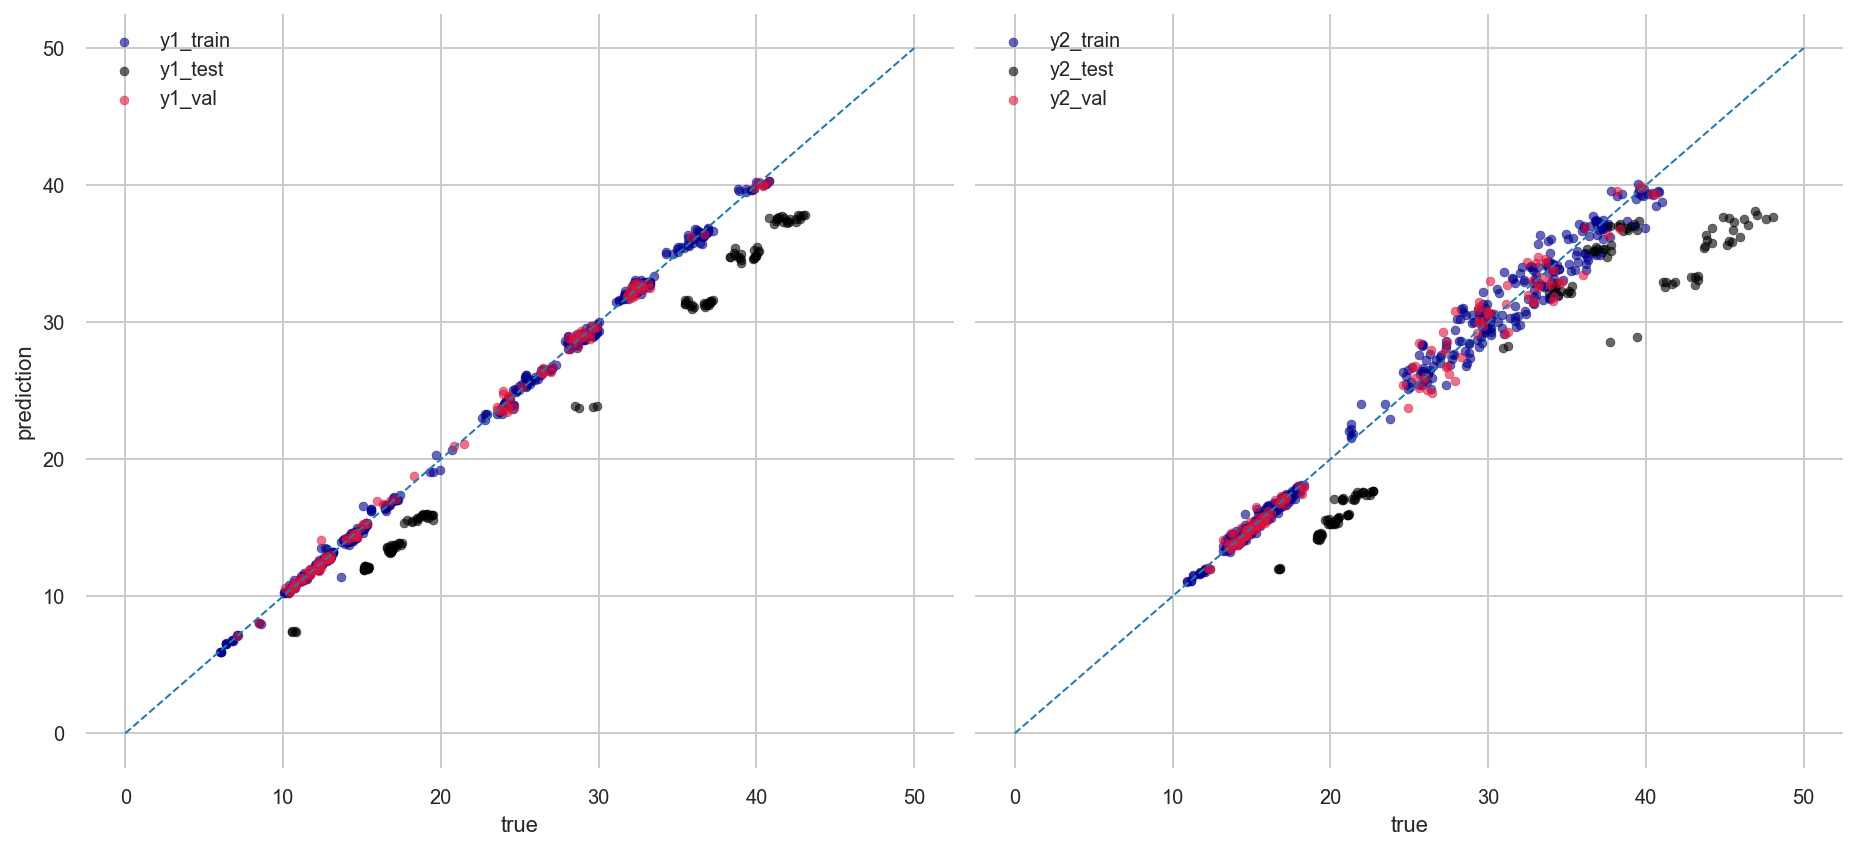

In [75]:
X_train = train[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_train = train[['Y1', 'Y2']]

X_test  = test[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_test  = test[['Y1', 'Y2']]

X_val   = validation[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_val   = validation[['Y1', 'Y2']]

y_test_scaled  = y_test.values*stds[['Y1', 'Y2']].values  + means[['Y1', 'Y2']].values
y_val_scaled   = y_val.values*stds[['Y1', 'Y2']].values   + means[['Y1', 'Y2']].values
y_train_scaled = y_train.values*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

# test
y1_test_pred = model1.predict(h2o.H2OFrame(X_test)).as_data_frame().values
y2_test_pred = model2.predict(h2o.H2OFrame(X_test)).as_data_frame().values
y_test_pred  = np.concatenate([y1_test_pred, y2_test_pred], axis=1)
y_test_pred_scaled = y_test_pred*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

# validation
y1_val_pred = model1.predict(h2o.H2OFrame(X_val)).as_data_frame().values
y2_val_pred = model2.predict(h2o.H2OFrame(X_val)).as_data_frame().values
y_val_pred  = np.concatenate([y1_val_pred, y2_val_pred], axis=1)
y_val_pred_scaled = y_val_pred*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

# train
y1_train_pred = model1.predict(h2o.H2OFrame(X_train)).as_data_frame().values
y2_train_pred = model2.predict(h2o.H2OFrame(X_train)).as_data_frame().values
y_train_pred  = np.concatenate([y1_train_pred, y2_train_pred], axis=1)
y_train_pred_scaled = y_train_pred*stds[['Y1', 'Y2']].values + means[['Y1', 'Y2']].values

fig, ax = plt.subplots(ncols=2, figsize=(13,6), sharey=True)

ax[0].scatter(x=y_train_scaled[:,0], y=y_train_pred_scaled[:,0], label='y1_train', color='darkblue', alpha=0.6, s=20.0)
ax[0].scatter(x=y_test_scaled[:,0],  y=y_test_pred_scaled[:,0],  label='y1_test',  color='black',    alpha=0.6, s=20.0)
ax[0].scatter(x=y_val_scaled[:,0],   y=y_val_pred_scaled[:,0],   label='y1_val',   color='crimson',  alpha=0.6, s=20.0)

ax[1].scatter(x=y_train_scaled[:,1], y=y_train_pred_scaled[:,1], label='y2_train', color='darkblue', alpha=0.6, s=20.0)
ax[1].scatter(x=y_test_scaled[:,1],  y=y_test_pred_scaled[:,1],  label='y2_test',  color='black',    alpha=0.6, s=20.0)
ax[1].scatter(x=y_val_scaled[:,1],   y=y_val_pred_scaled[:,1],   label='y2_val',   color='crimson',  alpha=0.6, s=20.0)

ax[0].plot([0,50],[0,50], lw=1.0, ls='--');
ax[1].plot([0,50],[0,50], lw=1.0, ls='--');

ax[0].legend()
ax[1].legend();

ax[0].set_xlabel('true')
ax[1].set_xlabel('true')

ax[0].set_ylabel('prediction')
    
fig.tight_layout()